# Example Fourier Frequency DEM Analysis

This python notebook will demonstrate the 2D Discrete Fourier Transform (DFT) applied to two gridded Digital Elevation Models (DEMs). This analysis can help highlight characteristic length scales in the natural landscape and also high-frequency noise present in the DEMs. 

For background reading see:

* Perron, J. T., Kirchner, J. W., and Dietrich, W. E.: Spectral signatures of characteristic spatial scales and nonfractal structure in landscapes, Journal of Geophysical Research, 113, 2008. [https://doi.org/10.1029/2007JF000866](https://doi.org/10.1029/2007JF000866)


* Purinton, B., and Bookhagen, B.: Validation of digital elevation models (DEMs) and geomorphic metrics on the southern Central Andean Plateau, Earth Surface Dynamics, 2017. [https://doi.org/10.5194/esurf-5-211-2017](https://doi.org/10.5194/esurf-5-211-2017)

## DEMs

To demonstrate this analysis we will use two DEMs with resolutions of 30 m:

1. The SRTM DEM: https://www2.jpl.nasa.gov/srtm/
2. The ASTER DEM: https://asterweb.jpl.nasa.gov/gdem.asp

In [1]:
# import some packages 
import numpy as np
from scipy import stats
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource



C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in power
C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log10


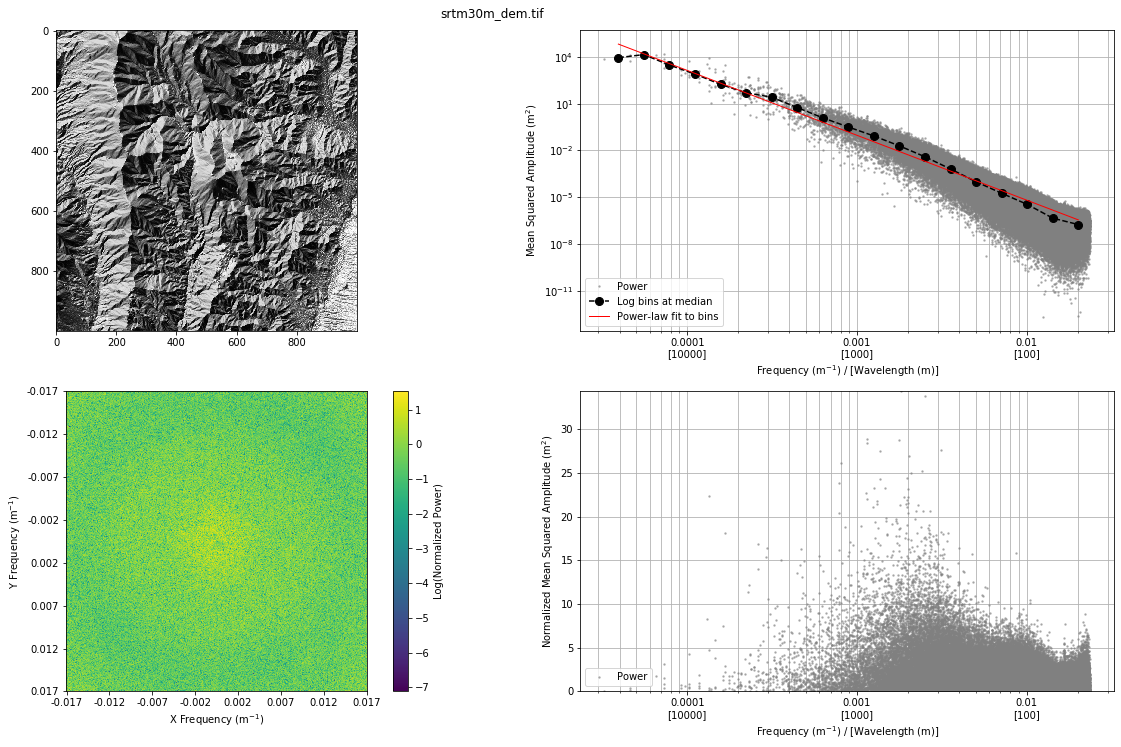

In [6]:
# get the DEMs of interest
fn = "srtm30m_dem.tif"
skip = 1


# open the raster, get resolution, save original for plots
f = rasterio.open(fn)
step = f.res[0]
z_original = f.read(1)
z = z_original.copy()
ny, nx = z.shape




# remove trend by fitting a plane
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

# hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

# This next step is done to optimize the Cooley and Turkey (1965) 
# Discrete Fourier Transfom (DFT) method used by numpy, which operates 
# most efficiently when the length scales are powers of 2 and the grid
# is square
Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

# frequency increments
dfx = 1/(step*Lx)
dfy = 1/(step*Ly)

# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# get the DFT periodogram with units of m^2 for topography 
# include weights of hann to correct for windowing
p2d = abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# calculate radial frequencies
xc, yc = (Lx//2 + 1, Ly//2 + 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))
fx = (x - xc) * dfx
fy = (y - yc) * dfy
f2d = np.sqrt(fx**2 + fy**2)

# get the frequency and power as 1D vectors
p1d = p2d[:, 0:xc].ravel()  # only half the power (reflected across the center)
f1d = f2d[:, 0:xc].ravel()  # same for the frequency

# bin the data using log bins
bins = 20
f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)
bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian, 
                                  bins=f_bins)
bin_center = edges[:-1] + np.diff(edges)/2

bin_center = bin_center[np.isfinite(bin_med)]
bin_med = bin_med[np.isfinite(bin_med)]

# apply a power-law fit to the bins
A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
pl_fit = (10**fit[1]) * (bin_center**fit[0])

# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))
# %%
# make a figure
fig, ax = plt.subplots(2, 2, figsize=(19.2, 10.8),
                               gridspec_kw={'left':0.1, 'right':0.95, 
                                            'bottom':0.1, 'top':0.95})
ax1, ax2, ax3, ax4 = ax[0, 1], ax[1, 1], ax[0, 0], ax[1, 0]
ax1.loglog(f1d[::skip], p1d[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax1.loglog(bin_center, bin_med, 'ko--', markersize=8, alpha=1, 
          label="Log bins at median")
ax1.loglog(bin_center, pl_fit, 'r-', lw=1, label="Power-law fit to bins")
ax1.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax1.get_xticks()])
ax1.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax1.set_ylabel('Mean Squared Amplitude (m$^2$)')
ax1.grid(True, which="both")
ax1.legend(loc='lower left', fontsize=10)

ax2.semilogx(f1d[::skip], p1d_norm[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax2.set_ylim(0, p1d_norm.max())
ax2.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax2.get_xticks()])
ax2.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax2.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax2.grid(True, which="both")
ax2.legend(loc='lower left', fontsize=10)
plt.suptitle(fn)

ls = LightSource(azdeg=315, altdeg=45)
ax3.imshow(ls.hillshade(z_original), cmap='gray')

im = ax4.imshow(np.log10(p2d_norm))
fig.colorbar(im, ax=ax4, label="Log(Normalized Power)")
ax4.set_xlabel("X Frequency (m$^{-1}$)")
ax4.set_ylabel("Y Frequency (m$^{-1}$)")
nfy, nfx = f2d.shape
nyq = f2d[nfy//2 + 1, 0]
n_labels = 8
ax4.set_xticks(np.linspace(1, nfx, n_labels))
ax4.set_yticks(np.linspace(1, nfy, n_labels))
ticks = ["{:.3f}".format(a) for a in np.linspace(-nyq, nyq, n_labels)]
ax4.set_xticklabels(ticks)
ax4.set_yticklabels(ticks)
plt.show()

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in power
C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in log10


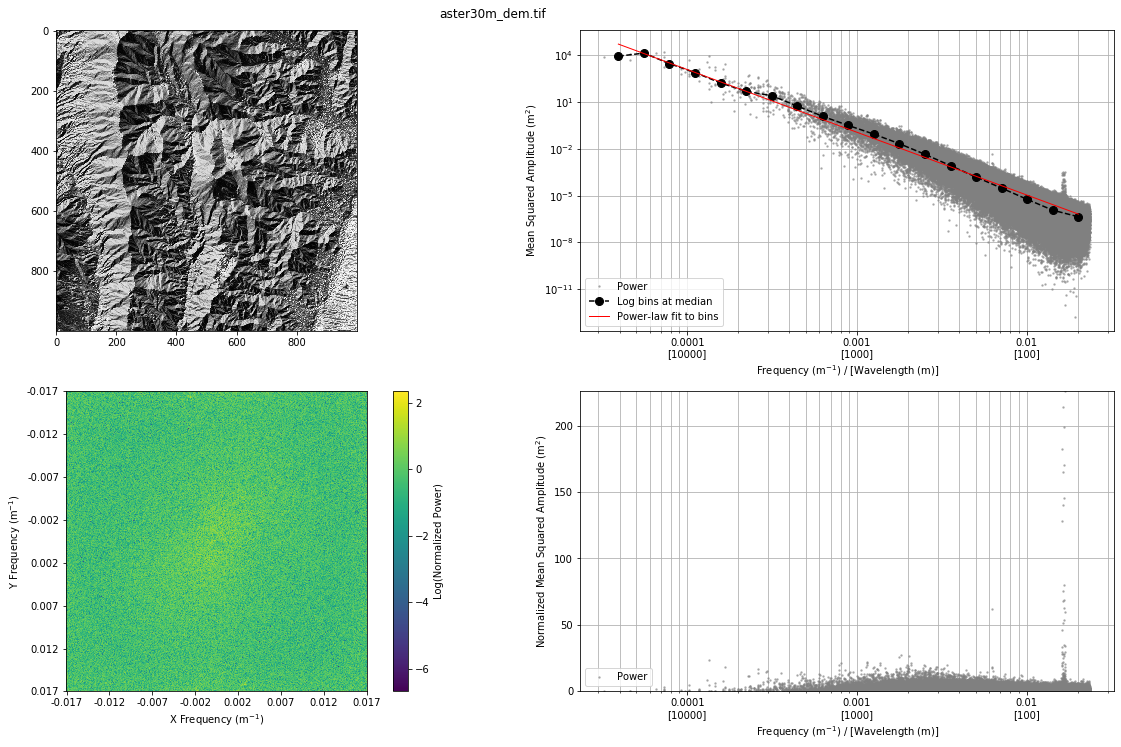

In [7]:
# get the DEMs of interest
fn = "aster30m_dem.tif"
skip = 1


# open the raster, get resolution, save original for plots
f = rasterio.open(fn)
step = f.res[0]
z_original = f.read(1)
z = z_original.copy()
ny, nx = z.shape




# remove trend by fitting a plane
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

# hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

# This next step is done to optimize the Cooley and Turkey (1965) 
# Discrete Fourier Transfom (DFT) method used by numpy, which operates 
# most efficiently when the length scales are powers of 2 and the grid
# is square
Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

# frequency increments
dfx = 1/(step*Lx)
dfy = 1/(step*Ly)

# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# get the DFT periodogram with units of m^2 for topography 
# include weights of hann to correct for windowing
p2d = abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# calculate radial frequencies
xc, yc = (Lx//2 + 1, Ly//2 + 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))
fx = (x - xc) * dfx
fy = (y - yc) * dfy
f2d = np.sqrt(fx**2 + fy**2)

# get the frequency and power as 1D vectors
p1d = p2d[:, 0:xc].ravel()  # only half the power (reflected across the center)
f1d = f2d[:, 0:xc].ravel()  # same for the frequency

# bin the data using log bins
bins = 20
f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)
bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian, 
                                  bins=f_bins)
bin_center = edges[:-1] + np.diff(edges)/2

bin_center = bin_center[np.isfinite(bin_med)]
bin_med = bin_med[np.isfinite(bin_med)]

# apply a power-law fit to the bins
A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
pl_fit = (10**fit[1]) * (bin_center**fit[0])

# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))
# %%
# make a figure
fig, ax = plt.subplots(2, 2, figsize=(19.2, 10.8),
                               gridspec_kw={'left':0.1, 'right':0.95, 
                                            'bottom':0.1, 'top':0.95})
ax1, ax2, ax3, ax4 = ax[0, 1], ax[1, 1], ax[0, 0], ax[1, 0]
ax1.loglog(f1d[::skip], p1d[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax1.loglog(bin_center, bin_med, 'ko--', markersize=8, alpha=1, 
          label="Log bins at median")
ax1.loglog(bin_center, pl_fit, 'r-', lw=1, label="Power-law fit to bins")
ax1.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax1.get_xticks()])
ax1.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax1.set_ylabel('Mean Squared Amplitude (m$^2$)')
ax1.grid(True, which="both")
ax1.legend(loc='lower left', fontsize=10)

ax2.semilogx(f1d[::skip], p1d_norm[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax2.set_ylim(0, p1d_norm.max())
ax2.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax2.get_xticks()])
ax2.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax2.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax2.grid(True, which="both")
ax2.legend(loc='lower left', fontsize=10)
plt.suptitle(fn)

ls = LightSource(azdeg=315, altdeg=45)
ax3.imshow(ls.hillshade(z_original), cmap='gray')

im = ax4.imshow(np.log10(p2d_norm))
fig.colorbar(im, ax=ax4, label="Log(Normalized Power)")
ax4.set_xlabel("X Frequency (m$^{-1}$)")
ax4.set_ylabel("Y Frequency (m$^{-1}$)")
nfy, nfx = f2d.shape
nyq = f2d[nfy//2 + 1, 0]
n_labels = 8
ax4.set_xticks(np.linspace(1, nfx, n_labels))
ax4.set_yticks(np.linspace(1, nfy, n_labels))
ticks = ["{:.3f}".format(a) for a in np.linspace(-nyq, nyq, n_labels)]
ax4.set_xticklabels(ticks)
ax4.set_yticklabels(ticks)
plt.show()